This module will focus on parameter typing and parameter sharing, which are commonly used in Deep learning for two main reasons:
1) Lower the number of unique model parameters
2) Increase network size

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense        │ (None, 8)         │        136 │ input_layer[0][0… │
│ (Dense)             │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16)        │          0 │ shared_dense[0][… │
│ (Concatenate)       │                   │            │ shared_dense[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         17 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 153 (612.00 B)

 Trainable params: 153 (612.00 B)

 Non-trainable params: 0 (0.00 B)

Shared layer weights have shape: (16, 8)


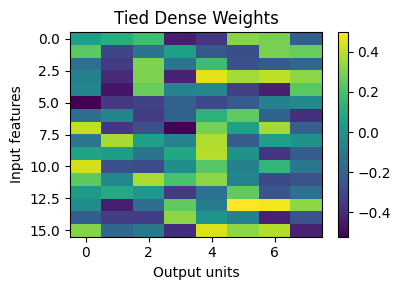

In [1]:
### Parameter typing with shared dense layers

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, layers

# 1. Create dummy data
N, D = 500, 16
x1 = np.random.randn(N, D).astype('float32')
x2 = np.random.randn(N, D).astype('float32')
y  = (np.sum(x1, axis=1) + np.sum(x2, axis=1) > 0).astype('int32')


# 2. Build two‐input model with a shared Dense layer
shared_dense = layers.Dense(8, activation='relu', name='shared_dense')

inp1 = layers.Input(shape=(D,))
inp2 = layers.Input(shape=(D,))

h1 = shared_dense(inp1)         # branch 1
h2 = shared_dense(inp2)         # branch 2 uses same weights

concat = layers.Concatenate()([h1, h2])
out    = layers.Dense(1, activation='sigmoid')(concat)

model_shared = Model([inp1, inp2], out)
model_shared.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
model_shared.summary()

# 3. Train briefly
model_shared.fit([x1, x2], y, epochs=5, batch_size=32, verbose=0)

# 4. Inspect that the weights are the same object
w1, b1 = shared_dense.weights
print("Shared layer weights have shape:", w1.shape)

# 5. Visualize the weight matrix
plt.figure(figsize=(4,3))
plt.title("Tied Dense Weights")
plt.imshow(w1.numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel("Output units")
plt.ylabel("Input features")
plt.tight_layout()
plt.show()

both branches are guaranteed to learn the same feature extraction, enforcing consistency across inputs.

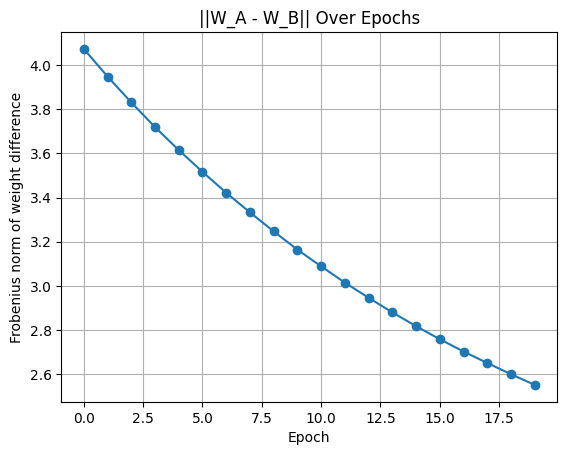

In [2]:
### Parameter typing with L2 regularization

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import matplotlib.pyplot as plt

# Dummy data (same as above)
N, D = 500, 16
x1 = np.random.randn(N, D).astype('float32')
x2 = np.random.randn(N, D).astype('float32')
y  = (np.sum(x1, axis=1) + np.sum(x2, axis=1) > 0).astype('int32')

# Separate dense layers
dense_A = layers.Dense(8, activation='relu', name='dense_A')
dense_B = layers.Dense(8, activation='relu', name='dense_B')

inp1 = layers.Input(shape=(D,))
inp2 = layers.Input(shape=(D,))

hA = dense_A(inp1)
hB = dense_B(inp2)

concat = layers.Concatenate()([hA, hB])
out    = layers.Dense(1, activation='sigmoid')(concat)

model_penalized = Model([inp1, inp2], out)

# Custom loss: BCE + λ * ||W_A - W_B||²
lambda_penalty = 1e-2

def custom_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    diff = dense_A.weights[0] - dense_B.weights[0]
    tie_penalty = lambda_penalty * tf.reduce_sum(tf.square(diff))
    return bce + tie_penalty

model_penalized.compile(optimizer='adam',
                        loss=custom_loss,
                        metrics=['accuracy'])

# Train and record weight difference over epochs
diff_history = []
for epoch in range(20):
    model_penalized.fit([x1, x2], y, epochs=1, batch_size=32, verbose=0)
    wA = dense_A.weights[0].numpy()
    wB = dense_B.weights[0].numpy()
    diff_history.append(np.linalg.norm(wA - wB))

# Plot how the parameter difference shrinks
plt.figure()
plt.plot(diff_history, marker='o')
plt.title("||W_A - W_B|| Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Frobenius norm of weight difference")
plt.grid(True)
plt.show()


The above graphs show the success of typing penalty, two independent initialized weight matrics are being pulled together.

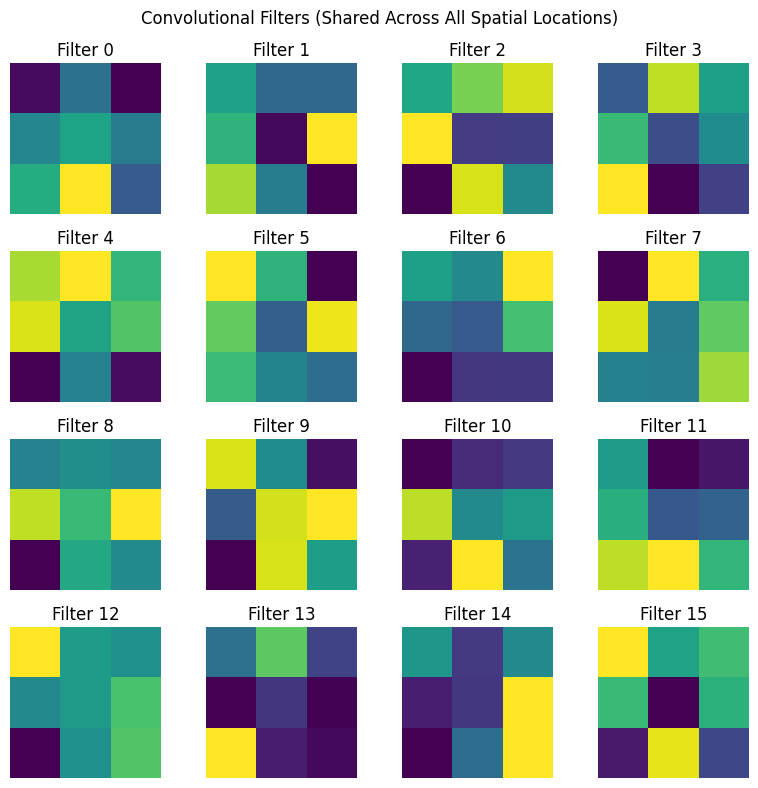

In [3]:
### Parameter sharing with convolutional layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

# 1. Load MNIST and take a small subset
(x_train, _), _ = mnist.load_data()
x_train = x_train[:1000].astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)  # shape (1000,28,28,1)

# 2. Build a simple conv‐only model to learn filters
inp = layers.Input(shape=(28,28,1))
conv = layers.Conv2D(16, kernel_size=3, activation='relu', name='conv_shared')(inp)
flat = layers.Flatten()(conv)
# Dummy head just to compile
out  = layers.Dense(10, activation='softmax')(flat)

model_conv = Model(inp, out)
model_conv.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy')

# Train briefly
dummy_labels = np.random.randint(0,10,size=(1000,))
model_conv.fit(x_train, dummy_labels, epochs=3, batch_size=64, verbose=0)

# 3. Extract and plot the 16 learned 3×3 filters
filters = model_conv.get_layer('conv_shared').get_weights()[0]  # shape (3,3,1,16)
filters = filters.squeeze(-2)  # shape (3,3,16)

n_filters = filters.shape[-1]
cols = 4
rows = (n_filters + cols - 1)//cols

plt.figure(figsize=(cols*2, rows*2))
for i in range(n_filters):
    plt.subplot(rows, cols, i+1)
    plt.imshow(filters[:,:,i], cmap='viridis', interpolation='nearest')
    plt.axis('off')
    plt.title(f'Filter {i}')
plt.suptitle("Convolutional Filters (Shared Across All Spatial Locations)")
plt.tight_layout()
plt.show()


Overall Conclusion:

Parameter Tying (first two plots) enforces that different parts of a model stay similar: 
    • A single layer object → exact sharing. 
    • A penalty → brings separate layers closer in weight space.

Parameter Sharing (third plot) exploits domain knowledge (translation invariance in images) to learn small, reusable filter banks that generalize across spatial locations.